# Example 4: Model Training
First we import the necessary modules

In [81]:
import torch
from torch.utils.data import DataLoader
from pythermondt import transforms as T
from pythermondt.data import ThermoDataset, DataContainer, random_split
from pythermondt.readers import S3Reader
from example_models.defect_classifier import UNetClassifier

First we define some general parameters for the model training

In [82]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set global random seed for reproducibility
torch.manual_seed(42)

# Model Hyperparameters
epochs = 50
batch_size = 16
learning_rate = 1e-4 # Standard learning rate for Adam optimizer

Now we can the define all the datasources used for training. Here you could specify multiple datasources (which are later combined using the dataset) if you need that. In this example we only use one datasource.

**Note:** For the S3Reader object we set the cache_files flag to true. Therefore all the files are cached to a folder (.pyThermoNDT_cache) in the current working directory. This makes training way faster, because the files are now only downloaded once and not every time the datasource is loaded. 

In [83]:
folder = "sanity_checked/noise_level0.025 confidence0.7"
base_path = "s3://ffg-bp/SAL-Dataset/" + folder
# Specify the datasource
no_defect = S3Reader(
    source=base_path + "/no_defect/.hdf5",
    cache_files=True,
    num_files=200
)

visible = S3Reader(
    source=base_path + "/defect_visible/.hdf5",
    cache_files=True,
    num_files = 200
)

Now we can combine these datasources by creating a dataset.

In [84]:
# Create a Dataset
dataset = ThermoDataset(data_source=[no_defect, visible])

Afterwards the transform pipeline which will be applied to the data before it gets fed into the model is defined. In this example we use Data Augmentation techniques like flipping and rotating the images or adding noise to the images (to simulate NETD of the camera). Therefore we need 2 different pipelines. One for the training set and one for the test set.

In [85]:
# Setup transform pipeline for training set
train_pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubtractFrame(0),
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(64),
    T.RandomFlip(p_height=0.3, p_width=0.3), # Data Augmentation
    T.GaussianNoise(std=25e-3), # Data Augmentation
    T.MinMaxNormalize(),
])

val_pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubtractFrame(0),
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(64),
    T.MinMaxNormalize(),
])

Before we can continue, we first need to write a custom collate function. All our readers and datasets always load data in form of Datacontainer objects. However, when training a model the input data needs to be in form of a tensor. Therefore the collate function extracts the data from all the Datacontainer objects in the current batch and stacks them along the batch dimension. It also makes sure that the shape of the data and the labels match the model input and output shape.

In [86]:
# Custom collate function to extract data and target from the DataContainers in the batch
def collate_fn(batch: list[DataContainer]) -> tuple[torch.Tensor, torch.Tensor]:
    # Extract data and target from the DataContainers
    tdata_list = []
    mask_list = []

    # Extract the data and label from the DataContainer
    for container in batch:
        # Extract datasets from the DataContainer
        tdata = container.get_dataset("/Data/Tdata")
        tdata = tdata.permute(2, 0, 1).float()  # Permute from (H, W, T) -> (T, H, W) and convert to float
        tdata_list.append(tdata)  # Append the tensor to the list
        mask_list.append(0 if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else 1)

    # Stack the tensors along the batch dimension
    data = torch.stack(tdata_list).to(device=device, dtype=torch.float32)
    label = torch.tensor(mask_list, device=device, dtype=torch.float32).unsqueeze(1)


    return data, label

Next we can split the dataset into a training and validation subset, using the random_split function provided with pyThermoNDT. Afterwards the dataloaders for each of the subsets are created.

In [87]:
# Split the dataset in train and test subsets
train_set, val_set = random_split(dataset, [0.8, 0.2], [train_pipeline, val_pipeline])

# Print the length of the subsets
print(f"Train set length: {len(train_set)}")
print(f"Test set length: {len(val_set)}")

# Create a DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Train set length: 320
Test set length: 80


Now lets verify that the loaders load the data with the correct dimensionality. The models expects the data in **B x C x H x W x T**:
* B ... Batchsize
* C ... Channels
* H / W ... Height / Width
* T ... Time dimension

In [88]:
for data, label in train_loader:
    print("Data Shape: ", data.shape)
    print("Label Shape: ", label.shape)
    break

Data Shape:  torch.Size([16, 64, 100, 100])
Label Shape:  torch.Size([16, 1])


Now that we have defined all the transform pipelines, lets also verify that the input to the model is correct. Lets plot some images from the training set and test set to see if the transformations are applied correctly.

defect


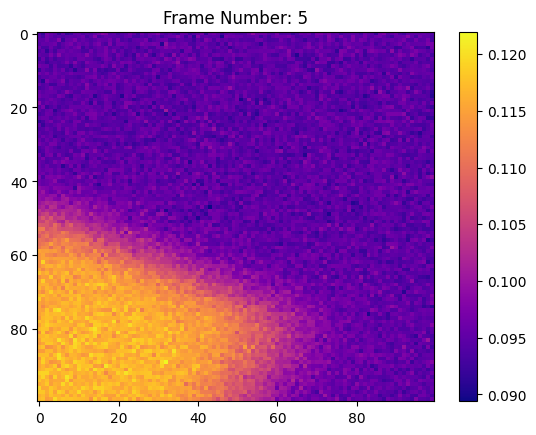

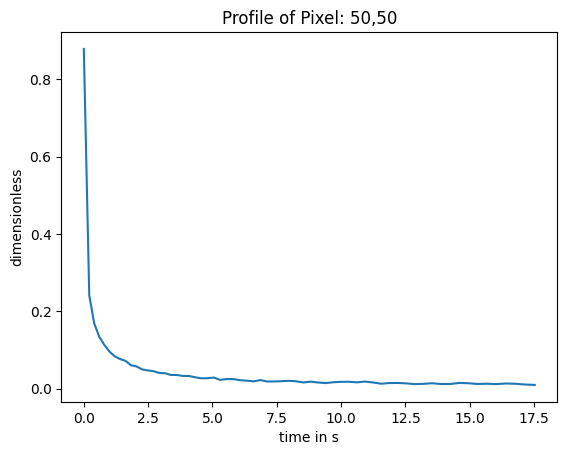

defect


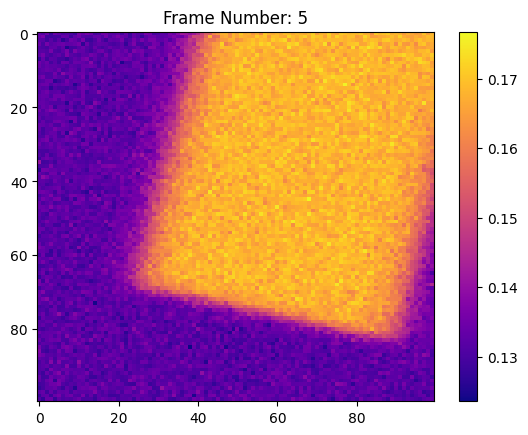

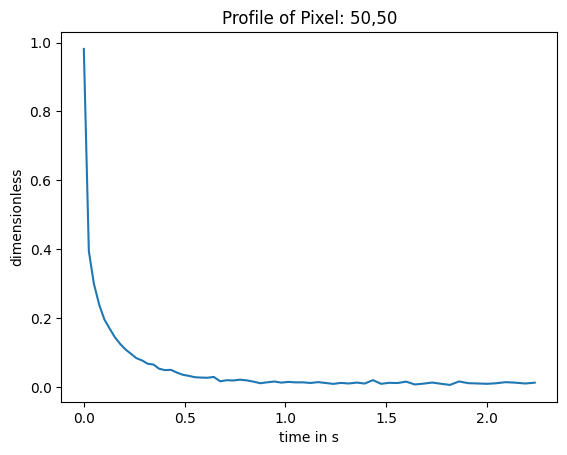

In [89]:
# Visualize the data input
# Visualize a no-defect sample
container = train_set[1]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

# Visualize a defect sample
container = train_set[2]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

Before we can start the training we also need to define the model, the loss function and the optimizer:

In [90]:
# Define the model and optimizer
model = UNetClassifier(time_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss()

Now we can run the training loop with the following code. The training loop is very simple and only consists of a few lines of code. For real world applications you might want to add more features like logging, early stopping, learning rate scheduling, etc.

In [91]:
# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch}")

    # Set the model to training mode
    model.train()
    print("Training:")
    for batch_idx, (data, label) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = loss_fn(output, label)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print the loss
        print(f"Batch {batch_idx}, Loss: {loss.item()}")

    # Evaluate the model
    with torch.no_grad():
        model.eval()
        val_loss_summed = 0
        print("Validation:")
        for batch_idx, (data, label) in enumerate(val_loader):
            # Forward pass
            output = model(data)

            # Compute the loss
            loss = loss_fn(output, label)
            val_loss_summed += loss.item()
        
        print(f"Validation Loss: {val_loss_summed / len(val_loader)}")

Epoch 0
Training:
Batch 0, Loss: 0.6941092014312744
Batch 1, Loss: 0.6933304071426392
Batch 2, Loss: 0.693145215511322
Batch 3, Loss: 0.6932888031005859
Batch 4, Loss: 0.6920247077941895
Batch 5, Loss: 0.693180501461029
Batch 6, Loss: 0.6915902495384216
Batch 7, Loss: 0.6933109760284424
Batch 8, Loss: 0.6904494166374207
Batch 9, Loss: 0.6861098408699036
Batch 10, Loss: 0.693851113319397
Batch 11, Loss: 0.6999353170394897
Batch 12, Loss: 0.70615553855896
Batch 13, Loss: 0.7103636264801025
Batch 14, Loss: 0.6846044063568115
Batch 15, Loss: 0.6978179216384888
Batch 16, Loss: 0.7009395360946655
Batch 17, Loss: 0.6965269446372986
Batch 18, Loss: 0.6959943175315857
Batch 19, Loss: 0.6954150199890137
Validation:
Validation Loss: 0.6928744912147522
Epoch 1
Training:
Batch 0, Loss: 0.6932172775268555
Batch 1, Loss: 0.6931939125061035
Batch 2, Loss: 0.6951199769973755
Batch 3, Loss: 0.6950122714042664
Batch 4, Loss: 0.692672610282898
Batch 5, Loss: 0.693152904510498
Batch 6, Loss: 0.693537652492

In [92]:
data, label = next(iter(train_loader))
output = model(data)
print("Labels: ", label)
print("Raw Model Outputs (logits):", output)

# Convert logits to probabilities to see what model thinks
logits = output.detach()
probs = torch.sigmoid(logits)
print("Probabilities:", probs.flatten())

# Check predictions vs labels
predictions = (probs > 0.5).float()
print("Predictions:", predictions.flatten())
print("Labels:     ", label.flatten())
print("Accuracy:", (predictions == label).float().mean().item())

Labels:  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')
Raw Model Outputs (logits): tensor([[-1.7118],
        [-1.2635],
        [-2.1558],
        [-1.4638],
        [-1.4587],
        [-2.6880],
        [ 7.1419],
        [23.4784],
        [-1.5743],
        [ 3.9583],
        [-2.0385],
        [ 9.0335],
        [-1.5257],
        [-2.3607],
        [-0.8814],
        [-2.8073]], device='cuda:0', grad_fn=<AddmmBackward0>)
Probabilities: tensor([0.1529, 0.2204, 0.1038, 0.1879, 0.1887, 0.0637, 0.9992, 1.0000, 0.1716,
        0.9813, 0.1152, 0.9999, 0.1786, 0.0862, 0.2929, 0.0569],
       device='cuda:0')
Predictions: tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')
Labels:      tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.